In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Recall



from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

print("GPUs disponíveis:", len(tf.config.list_physical_devices('GPU')))


GPUs disponíveis: 0


In [ ]:
# # Função de pré-processamento
# def preprocess_image(image, label):
#     # Redimensiona a imagem para o tamanho esperado pela InceptionV3 (299x299)
#     image = tf.image.resize(image, (75, 75))

#     # Normaliza os valores de pixel para o intervalo [0, 1]
#     image = image / 255.0

#     return image, label

# Carregar o dataset de imagens de malária
ds = tfds.load(
    'malaria',
    split='train',  # Dividindo em treino e teste
    shuffle_files=True,
    as_supervised=True  # Retorna tuplas (imagem, label)
)


# Visualizando as imagens pré-processadas
def show_images_with_info(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        print(f"\nImagem {i+1}:")
        print(f" - Dimensões: {image.shape}")
        print(f" - Valor mínimo dos pixels: {tf.reduce_min(image).numpy()}")
        print(f" - Valor máximo dos pixels: {tf.reduce_max(image).numpy()}")
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title("Infectada" if label == 1 else "Saudável")
        plt.axis('off')
    plt.show()

# Visualizando algumas amostras
show_images_with_info(ds, 6)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
tamanho = tf.data.experimental.cardinality(ds).numpy()
print(f"Tamanho do dataset: {tamanho}")

Tamanho do dataset: 27558



Imagem 1:
 - Dimensões: (75, 75, 3)
 - Valor mínimo dos pixels: 0.0
 - Valor máximo dos pixels: 0.7831529378890991

Imagem 2:
 - Dimensões: (75, 75, 3)
 - Valor mínimo dos pixels: 0.0
 - Valor máximo dos pixels: 0.8748235106468201

Imagem 3:
 - Dimensões: (75, 75, 3)
 - Valor mínimo dos pixels: 0.0
 - Valor máximo dos pixels: 0.8807054758071899

Imagem 4:
 - Dimensões: (75, 75, 3)
 - Valor mínimo dos pixels: 0.0
 - Valor máximo dos pixels: 0.8611263036727905

Imagem 5:
 - Dimensões: (75, 75, 3)
 - Valor mínimo dos pixels: 0.0
 - Valor máximo dos pixels: 0.7767319679260254

Imagem 6:
 - Dimensões: (75, 75, 3)
 - Valor mínimo dos pixels: 0.0
 - Valor máximo dos pixels: 0.8335372805595398


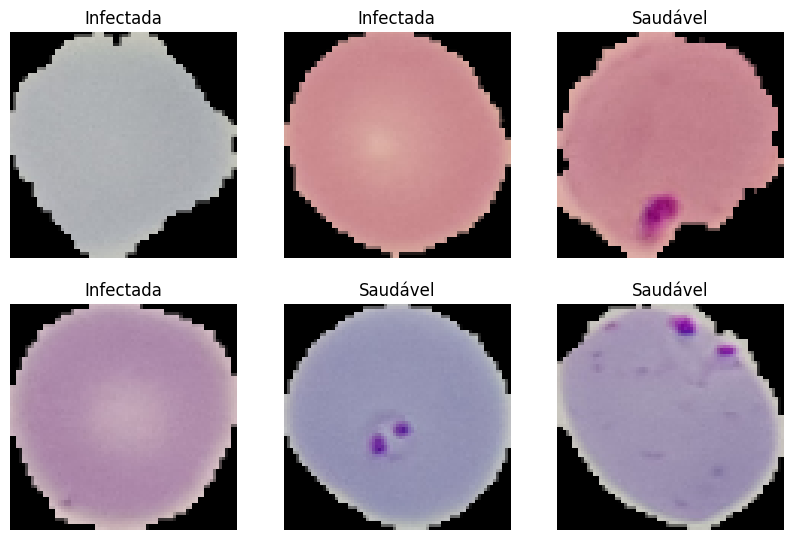

In [ ]:
# Função de pré-processamento
def preprocess_image(image, label):
    # Redimensiona a imagem para o tamanho esperado pela InceptionV3 (299x299)
    image = tf.image.resize(image, (75, 75))

    # Normaliza os valores de pixel para o intervalo [0, 1]
    image = image / 255.0

    return image, label

# Teste de pré-processamento a todo o dataset
ds_all_preprocessed = ds.map(preprocess_image)

# Visualizando as imagens pré-processadas
def show_images_with_info(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        print(f"\nImagem {i+1}:")
        print(f" - Dimensões: {image.shape}")
        print(f" - Valor mínimo dos pixels: {tf.reduce_min(image).numpy()}")
        print(f" - Valor máximo dos pixels: {tf.reduce_max(image).numpy()}")
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title("Infectada" if label == 1 else "Saudável")
        plt.axis('off')
    plt.show()


show_images_with_info(ds_all_preprocessed, 6)


In [ ]:
# # Converter o dataset para listas (ou arrays do NumPy)
images = []
labels = []
for image, label in ds_all_preprocessed:
    images.append(image.numpy())
    labels.append(label.numpy())

images = np.array(images)
labels = np.array(labels)


# Divisão usando train_test_split
# Primeiro, dividir em treino (70%) e restante (30%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

# Agora, dividir o restante em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Data Augmentation para o conjunto de treino
data_augmentation = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    height_shift_range=0.2,
    width_shift_range=0.2,
    zoom_range=0.2
)



In [ ]:
print(labels)

[1 1 0 ... 1 0 1]


In [ ]:
def create_model(input_shape=(75, 75, 3), num_classes=1, l2_lambda=0.01):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Carregar a InceptionV3 pré-treinada na ImageNet, sem incluir a cabeça densa final
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)

    # Congelar as camadas da InceptionV3 para não serem treinadas
    # base_model.trainable = False

    # Definir a nova cabeça personalizada
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Adicionar a camada de classificação final
    predictions = Dense(num_classes, activation='sigmoid')(x)  # Para classificação binária

    # Definir o modelo final
    model = Model(inputs=inputs, outputs=predictions)

    return model

In [ ]:
epochs = 20
batch_size = 32

In [ ]:
#loss='sparse_categorical_crossentropy',
def compile_model(model):
    # Compilar o modelo
    model.compile(optimizer=SGD(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall()])

    return model

In [ ]:
model = create_model()
model = compile_model(model)
#model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
print(X_train.shape)

(19290, 75, 75, 3)


In [ ]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)
y_test = np.squeeze(y_test)


train_datagen = data_augmentation.flow(X_train, y_train, batch_size=batch_size)
val_datagen = data_augmentation.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
train_datagen = data_augmentation.flow(X_train, y_train, batch_size=batch_size)
val_datagen = data_augmentation.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
# Treinar o modelo
history = model.fit(train_datagen,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=val_datagen,
                    epochs=epochs)

# Avaliar o modelo no conjunto de teste (sem ImageDataGenerator)
test_loss, test_acc, test_recall = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Acurácia no conjunto de teste: {test_acc * 100:.2f}%")

# Predições para o conjunto de teste
y_pred = model.predict(X_test)



Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 56s 92ms/step - accuracy: 0.8768 - loss: 0.3169 - recall: 0.9356 - val_accuracy: 0.8728 - val_loss: 0.3416 - val_recall: 0.9313
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.8795 - loss: 0.3094 - recall: 0.9372 - val_accuracy: 0.8885 - val_loss: 0.2942 - val_recall: 0.9448
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.8811 - loss: 0.3068 - recall: 0.9385 - val_accuracy: 0.8909 - val_loss: 0.3031 - val_recall: 0.9439
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.8876 - loss: 0.2931 - recall: 0.9410 - val_accuracy: 0.8967 - val_loss: 0.2907 - val_recall: 0.9448
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.8928 - loss: 0.2878 - recall: 0.9487 - val_accuracy: 0.8911 - val_loss: 0.2871 - val_recall: 0.9448
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.8925 - loss: 0.2883 - recall: 0.9429 - val_accuracy: 0.8914 - val_loss: 0.2853 - val_recall:

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'recall', 'val_accuracy', 'val_loss', 'val_recall'])

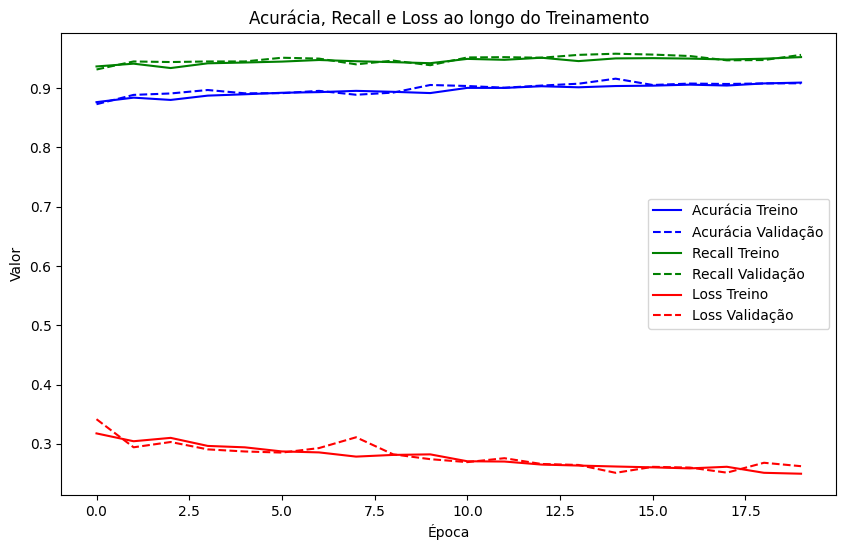

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar as métricas no mesmo gráfico
def plot_training_metrics(history):
    plt.figure(figsize=(10, 6))

    # Plotando as curvas
    plt.plot(history.history['accuracy'], label='Acurácia Treino', color='blue')
    plt.plot(history.history['val_accuracy'], label='Acurácia Validação', color='blue', linestyle='--')

    plt.plot(history.history['recall'], label='Recall Treino', color='green')
    plt.plot(history.history['val_recall'], label='Recall Validação', color='green', linestyle='--')

    plt.plot(history.history['loss'], label='Loss Treino', color='red')
    plt.plot(history.history['val_loss'], label='Loss Validação', color='red', linestyle='--')

    # Configurando título e eixos
    plt.title('Acurácia, Recall e Loss ao longo do Treinamento')
    plt.xlabel('Época')
    plt.ylabel('Valor')
    plt.legend(loc='best')

    plt.show()

# Chamando a função para plotar
plot_training_metrics(history)


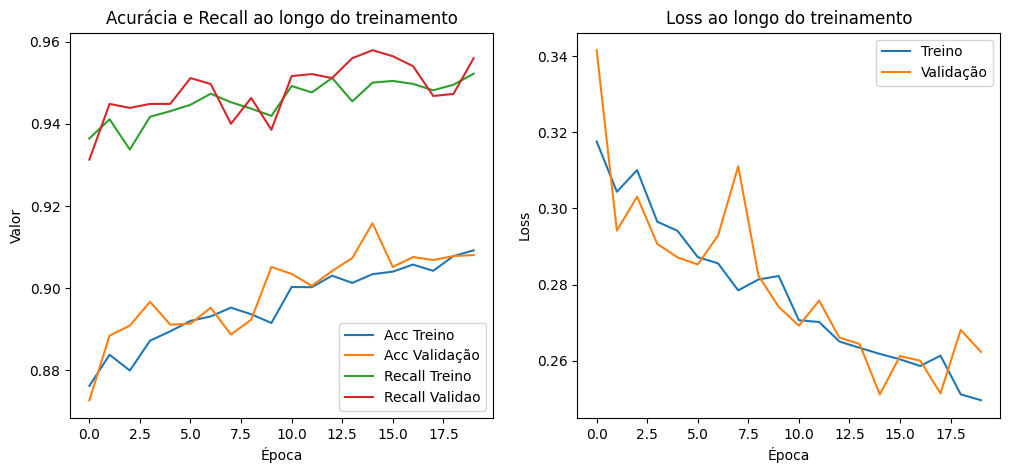

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar loss e acurácia
def plot_training_history(history):
    # Acurácia
    plt.figure(figsize=(12, 5))

    # Plotando acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acc Treino')
    plt.plot(history.history['val_accuracy'], label='Acc Validação')
    plt.plot(history.history['recall'], label="Recall Treino")
    plt.plot(history.history['val_recall'], label="Recall Validao")
    plt.title('Acurácia e Recall ao longo do treinamento')
    plt.xlabel('Época')
    plt.ylabel('Valor')
    plt.legend()

    # Plotando loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Loss ao longo do treinamento')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Chamando a função para plotar os gráficos
plot_training_history(history)


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


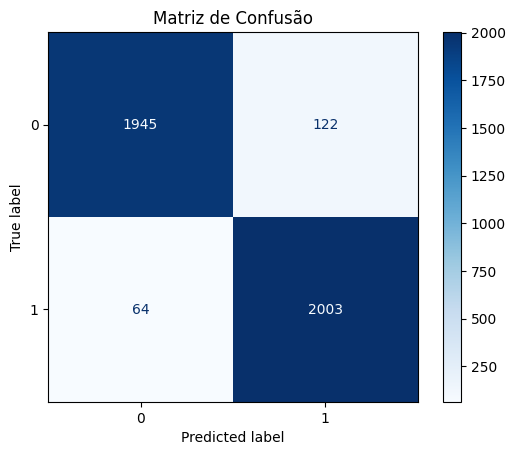

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Com o conjunto de validação
# Pegando as previsões no conjunto de validação
y_pred = model.predict(X_val)

# Convertendo as previsões de probabilidades para classes binárias (0 ou 1)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

# Obtendo os labels verdadeiros diretamente dos dados de validação (y_val)
y_true = y_val[:len(y_pred_classes)]  # Usar os rótulos verdadeiros de validação/teste

# Gerando a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


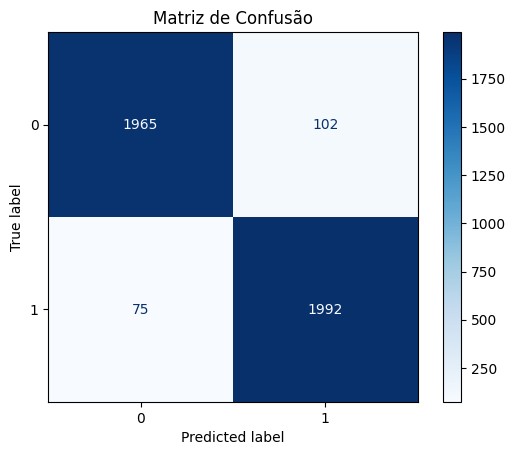

In [ ]:
#Com conjunto de teste
# Pegando as previsões no conjunto de validação
y_pred = model.predict(X_test)

# Convertendo as previsões de probabilidades para classes binárias (0 ou 1)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

# Obtendo os labels verdadeiros diretamente dos dados de validação (y_val)
y_true = y_test[:len(y_pred_classes)]  # Usar os rótulos verdadeiros de validação/teste

# Gerando a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Binarizar as predições para 0 e 1

# Imprimir o classification report
print("\nClassification Report:")
print(classification_report(y_test[:len(y_pred)], y_pred, target_names=["Saudável", "Infectada"]))

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Classification Report:
              precision    recall  f1-score   support

    Saudável       0.96      0.95      0.96      2067
   Infectada       0.95      0.96      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


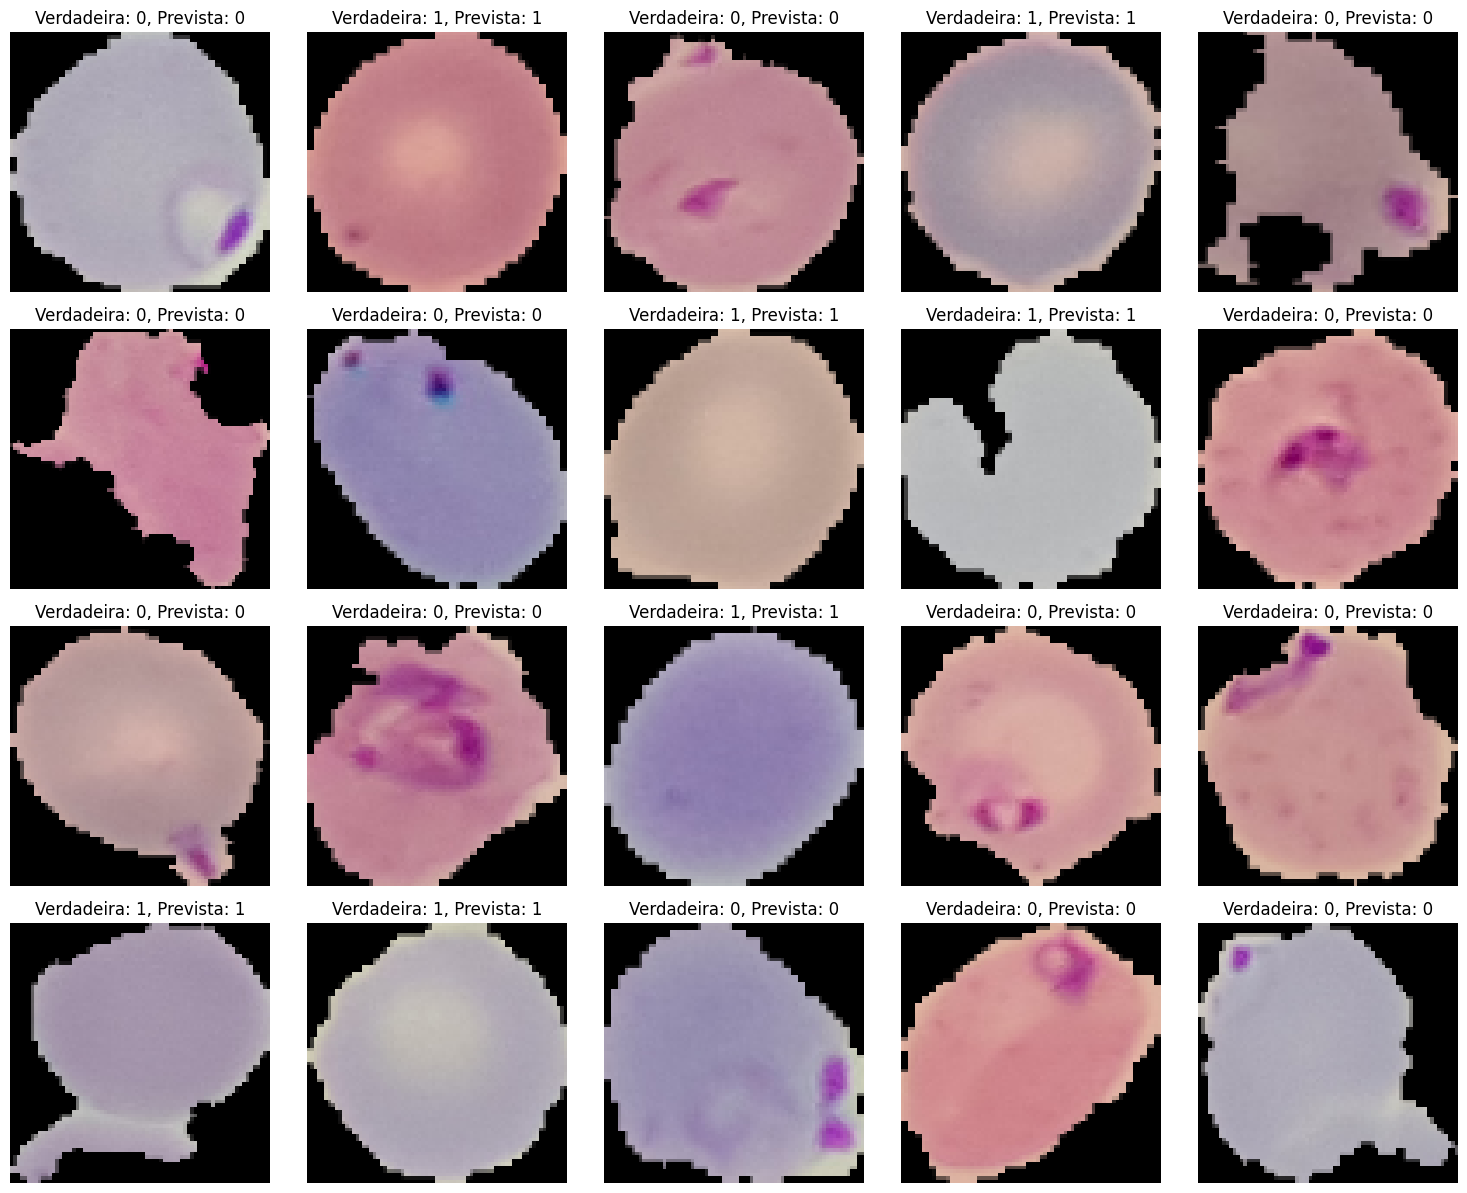

In [ ]:
#Plotar alguns exemplos

# Número de exemplos que você deseja visualizar
num_examples = 20

# Pegando um batch de dados do conjunto de validação (ou teste)
# O gerador deve estar configurado para não embaralhar os dados
# images, true_labels = next(X_test)

images = X_test[:num_examples]
true_labels = y_test[:num_examples]

# Gerando previsões para essas imagens
predictions = model.predict(images)

# Convertendo as previsões de probabilidades para classes binárias (0 ou 1)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Plotando as imagens com as labels verdadeiras e previstas
plt.figure(figsize=(15, 15))

for i in range(num_examples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Verdadeira: {true_labels[i]}, Prevista: {predicted_labels[i][0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
